# Predict Remaining Useful Life

In this example, we will generate labels using Compose on data provided by NASA simulating turbofan engine degradation. The labels can be used to train a machine learning model to predict whether ...

In [1]:
import composeml as cp
import data

## Load Data
You can download the data directly from NASA [here](https://ti.arc.nasa.gov/c/13/). After downloading the data, you can set `file` as an absolute path to the file `train_FD004.txt`.


### Description
The data is a single table of sensor observations over time.

In [2]:
df = data.load('data/train_FD004.txt')

df[df.columns[:7]].head()

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2
0,1,1,42.0049,0.8400,100.0,445.00,549.68
1,1,2,20.0020,0.7002,100.0,491.19,606.07
2,1,3,42.0038,0.8409,100.0,445.00,548.95
3,1,4,42.0000,0.8400,100.0,445.00,548.70
4,1,5,25.0063,0.6207,60.0,462.54,536.10


## Generate Labels

### Define Labeling Function

In [3]:
def remaining_useful_life(df):
    length = len(df) - 1
    return length

### Create Label Maker

In [4]:
lm = cp.LabelMaker(
    target_entity='engine_no',
    time_index='time',
    labeling_function=remaining_useful_life,
)

### Search Labels

In [5]:
lt = lm.search(
    df.sort_values('time'),
    num_examples_per_instance=5,
    gap=1,
    verbose=True,
)

lt.head()

Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████| engine_no: 1245/1245 


,engine_no,cutoff_time,remaining_useful_life
id,,,
0,1,2000-01-01 00:00:00,320
1,1,2000-01-01 00:10:00,319
2,1,2000-01-01 00:20:00,318
3,1,2000-01-01 00:30:00,317
4,1,2000-01-01 00:40:00,316


### Describe Labels

With the generate label times, we can use `LabelTimes.describe` to print out the distribution with the settings and transforms that were used to make these labels. This is useful as a reference for understanding how the labels were generated from raw data. Also, the label distribution is helpful for determining if we have imbalanced labels.

In [6]:
lt.describe()

Settings
--------
num_examples_per_instance        5.0
minimum_data                     NaN
window_size                  61249.0
gap                              1.0


Transforms
----------
No transforms applied



### Plot Labels

Additionally, there are plots available for insight to the labels.


#### Distribution

This plot shows the label distribution.

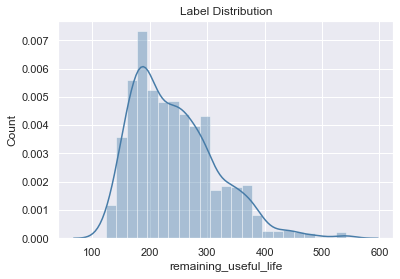

In [7]:
lt.plot.distribution();

#### Count by Time

This plot shows the label distribution across cutoff times.

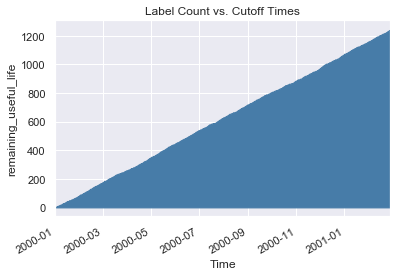

In [8]:
lt.plot.count_by_time();